In [62]:
import pulp as plp
from ALB_instance_tools import *
import numpy as np
import pandas as pd
import os
import networkx as nx

In [63]:
! pwd


/Users/letshopethisworks2/Documents/Phd Paper material/MMABPWW


In [64]:

#Gets list of all instance (.alb) files in the SALBP_benchmark/small\ data\ set_n\=20 folder
instance_list = get_instance_list('SALBP_benchmark/small data set_n=20')
#instance_list = get_instance_list('SALBP_benchmark/large data set_n=100')
#sorts instance list by instance number
instance_list = sorted(instance_list, key=lambda k: int(k['name'].split("_")[1]))



In [65]:

def define_ALBP_1_problem(instance, max_stations = 20):
    prob = plp.LpProblem("ALPB_1", plp.LpMinimize)
    #creating decision variables
    tasks = plp.LpVariable.dicts("task_o_s", (instance['task_times'].keys(), range(1,max_stations + 1)), cat='Binary')
    #objective function
    prob += plp.lpSum([ station * tasks[task][station] for station in range(1,max_stations + 1) for task in instance['task_times'].keys()])
    #definining constraints
    #constraint 1 only choose 1 station for each task
    for task in instance['task_times'].keys():
        prob += plp.lpSum([tasks[task][station] for station in range(1,max_stations + 1)]) == 1
    #constraint 2 task and station assignment must respect takt time
    for station in range(1,max_stations + 1):
        prob += plp.lpSum([instance['task_times'][task] * tasks[task][station] for task in instance['task_times'].keys()]) <= instance['cycle_time']
    #constraint 3 tasks must respect precedence constraints
    for precedence in instance['precedence_relations']:
        prob += plp.lpSum([station * tasks[precedence[0]][station] for station in range(1,max_stations + 1)]) <= plp.lpSum([station * tasks[precedence[1]][station] for station in range(1,max_stations + 1)])
    return prob

def solve_ALBP_1(instance, max_stations = 20):
    prob = define_ALBP_1_problem(instance, max_stations)
    prob.solve(solver=plp.XPRESS_PY( msg=False))
    max_station = -10
    task_assignment = {}
    for variable in prob.variables():
        if variable.varValue > 0:
            task = variable.name.split("_")[3]
            station = variable.name.split("_")[4]
            #Adds dictionary where key is the task and value is the station
            task_assignment[task] = station
            #Find the largest station number that is used
            if int(station) > max_station:
                max_station = int(station)
    return max_station, task_assignment




In [66]:
def get_ALBP_solutions(problems_list, ALBP_solver = solve_ALBP_1, max_stations = 20, **kwargs):
    solutions = []
    for problem in problems_list:
        instance = parse_alb(problem['location'])
        print('solving problem', problem['name'])
        no_stations, task_assignment = ALBP_solver(instance, max_stations = max_stations,**kwargs)
        #creates a new dictionary entry that contains the data on the instances
        
        entry = {'name':problem['name']}
        entry['no_tasks'] = len(instance['task_times'].keys())
        entry['order_strength'] = instance['order_strength']
        entry['cycle_time'] = instance['cycle_time']
        entry['no_stations'] = no_stations
        entry['task_assignment'] = task_assignment
        solutions.append(entry)
    return solutions
solution_outputs = get_ALBP_solutions([instance_list[0]])

solving problem 20_1


In [67]:
solution_outputs = get_ALBP_solutions([instance_list[15]])

solving problem 20_16


In [68]:
solution_outputs

[{'name': '20_16',
  'no_tasks': 20,
  'order_strength': 0.232,
  'cycle_time': 1000,
  'no_stations': 12,
  'task_assignment': {'10': '11',
   '11': '9',
   '12': '7',
   '13': '3',
   '14': '7',
   '15': '10',
   '16': '5',
   '17': '4',
   '18': '12',
   '19': '11',
   '1': '4',
   '20': '5',
   '2': '1',
   '3': '2',
   '4': '1',
   '5': '8',
   '6': '6',
   '7': '2',
   '8': '3',
   '9': '6'}}]

In [69]:
# solution_outputs = pd.DataFrame(solution_outputs)
# solution_outputs.to_csv('ALBP_1_solutions.csv')

In [70]:
#Scoring functions
def task_time_weight(tasks_dict, instance):
    for task in tasks_dict.keys():
        tasks_dict[task]['score'] = instance['task_times'][task]

def backwards_recursive_positional_weight(tasks_dict, instance):
    #calculates the positional weight of each task of the instance
    p_graph = nx.DiGraph()
    p_graph.add_nodes_from([(key, {'task_time':value}) for key, value in instance["task_times"].items()])
    p_graph.add_edges_from(instance["precedence_relations"], color="r")
    weights = {}
    while len(p_graph.nodes) > 0:
        leaves = []
        for n in p_graph.nodes():
            if not list(p_graph.successors(n)):
                weights[n] = p_graph.nodes[n]['task_time']
                leaves.append(n)
                for p in p_graph.predecessors(n):
                    p_graph.nodes[p]['task_time'] += p_graph.nodes[n]['task_time']
        p_graph.remove_nodes_from(leaves)
    for weight in weights.keys():
        tasks_dict[weight]['score'] = weights[weight]


def collect_parents(p_graph):
    '''Collects the parents of each node in a graph and returns a dictionary with the node as key and the set of parents as value'''
    weight_set = {}
    while len(p_graph.nodes) > 0:
        leaves = []
        for n in p_graph.nodes():
            if not list(p_graph.successors(n)):
                weight_set[n] = p_graph.nodes[n]['task_set']
                leaves.append(n)
                for p in p_graph.predecessors(n):
                    p_graph.nodes[p]['task_set'] =  p_graph.nodes[p]['task_set'].union(p_graph.nodes[n]['task_set'])
        p_graph.remove_nodes_from(leaves)
    return weight_set

def reverse_positional_weight(tasks_dict, instance):
    #calculates the reverse positional weight of each task of the instance
    p_graph = nx.DiGraph()
    p_graph.add_nodes_from([(key, {'task_time':value, 'task_set':set([key])}) for key, value in instance["task_times"].items()])
    p_graph.add_edges_from(instance["precedence_relations"], color="r")
    p_graph = p_graph.reverse()
    weight_set = collect_parents(p_graph)
    for weight in weight_set.keys():
        tasks_dict[weight]['score'] = sum([instance['task_times'][task] for task in weight_set[weight]])

def positional_weight(tasks_dict, instance):
    #calculates the positional weight of each task of the instance
    p_graph = nx.DiGraph()
    p_graph.add_nodes_from([(key, {'task_time':value, 'task_set':set([key])}) for key, value in instance["task_times"].items()])
    p_graph.add_edges_from(instance["precedence_relations"], color="r")
    weight_set = collect_parents(p_graph)
    for weight in weight_set.keys():
        tasks_dict[weight]['score'] = sum([instance['task_times'][task] for task in weight_set[weight]])


def rank_and_assign_initialization(instance,score_function, max_stations = 20):
    station_capacities = [instance['cycle_time'] for i in range(0, max_stations)]
    tasks_dict = {}
    for task in instance['task_times'].keys():
        task_dict = {}
        task_dict['predecessors'] = [precedence[0] for precedence in instance['precedence_relations'] if precedence[1] == task]
        tasks_dict[task] = task_dict
    score_function(tasks_dict, instance)
    #sorts tasks_dict by score
    tasks_dict = {k: v for k, v in sorted(tasks_dict.items(), key=lambda item: item[1]['score'])}
     
    return tasks_dict, station_capacities

#fills up each station with available tasks in order of score
def insert_task(instance, tasks_dict, station_capacities, assignment_dict):
    for index, station in enumerate(station_capacities):
            for task in tasks_dict.keys():
                if instance['task_times'][task] <= station and all(predecessor not in tasks_dict.keys() for predecessor in tasks_dict[task]['predecessors']):
                    station_capacities[index] -= instance['task_times'][task]
                    assignment_dict[task] = index + 1
                    tasks_dict.pop(task)
                    return
    raise ValueError(f'no task can be assigned to any station (try adding more stations)')

# RA heuristic as described in "A comparative Evaluation of Heuristics for the Assembly Line Balancing Problem" by Ponnanbalam et. al              
def rank_and_assign( instance,score_function, max_stations = 20):
    task_assignment = {}
    tasks_dict, station_capacities = rank_and_assign_initialization(instance, score_function, max_stations)
    #Inserts tasks into stations until there are no more tasks
    while len(tasks_dict.keys()) > 0:
        insert_task(instance, tasks_dict, station_capacities, task_assignment)
    return  sum([1 for station in station_capacities if station < instance['cycle_time']]),task_assignment

instance = parse_alb(instance_list[16]['location'])

stations, task_assignment1  = rank_and_assign(instance, positional_weight, max_stations = 30)
stations


11

In [71]:

p_graph = nx.DiGraph()

p_graph.add_nodes_from([(key, {'task_time':value}) for key, value in instance["task_times"].items()])
p_graph.add_edges_from(instance["precedence_relations"], color="r")
    
colors = [p_graph[u][v]["color"] for u, v in p_graph.edges]
weights = []
while len(p_graph.nodes) > 1:
    leaves = []
    for n in p_graph.nodes():
        if not list(p_graph.successors(n)):
            weights.append({'task': n, 'pos_weight':p_graph.nodes[n]['task_time']})
            leaves.append(n)
            for p in p_graph.predecessors(n):
                p_graph.nodes[p]['task_time'] += p_graph.nodes[n]['task_time']
    p_graph.remove_nodes_from(leaves)


print(weights)

[{'task': '5', 'pos_weight': 271}, {'task': '6', 'pos_weight': 386}, {'task': '11', 'pos_weight': 409}, {'task': '14', 'pos_weight': 334}, {'task': '15', 'pos_weight': 491}, {'task': '16', 'pos_weight': 420}, {'task': '17', 'pos_weight': 513}, {'task': '18', 'pos_weight': 409}, {'task': '19', 'pos_weight': 381}, {'task': '20', 'pos_weight': 698}, {'task': '12', 'pos_weight': 1128}, {'task': '13', 'pos_weight': 2883}, {'task': '1', 'pos_weight': 3407}, {'task': '2', 'pos_weight': 3536}, {'task': '7', 'pos_weight': 3443}, {'task': '9', 'pos_weight': 2159}, {'task': '10', 'pos_weight': 3183}, {'task': '4', 'pos_weight': 2639}, {'task': '8', 'pos_weight': 3656}]


In [72]:
#inserts tasks into first available station
def insert_task_iuff(instance, task, tasks_dict,assignment_dict, station_capacities):
    for index, station_cap in enumerate(station_capacities):
            if instance['task_times'][task] <= station_cap:
                if tasks_dict[task]['available_after'] <= index + 1:
                    station_capacities[index] -= instance['task_times'][task]
                    assignment_dict[task] = index + 1
                    tasks_dict.pop(task)
                    return


def update_tasks(tasks_dict, assignment_dict):
    available_tasks = []
    for task in tasks_dict.keys():
            #if all predecessors are assigned to a station, mark task as available
            if tasks_dict[task]['available_after'] == 'unavailable':
                if all([predecessor in  assignment_dict.keys() for predecessor in tasks_dict[task]['predecessors']]):
                    tasks_dict[task]['available_after'] = max([assignment_dict[predecessor] for predecessor in tasks_dict[task]['predecessors']])
                    return task
            else:
                return task


def iuff_initialization(instance, score_function, max_stations = 20):
    station_capacities = [instance['cycle_time'] for i in range(0, max_stations)]
    tasks_dict = {}
    available_tasks = []
    for task in instance['task_times'].keys():
        task_dict = {}
        task_dict['predecessors'] = [precedence[0] for precedence in instance['precedence_relations'] if precedence[1] == task]
        #adds tasks with no predecessors to available tasks
        if not task_dict['predecessors']:
            task_dict['available_after'] = 0
            available_tasks.append(task)
        else:
            task_dict['available_after'] = 'unavailable'
        tasks_dict[task] = task_dict
    #sorts tasks_dict by score
    score_function(tasks_dict, instance)
    tasks_dict = {k: v for k, v in sorted(tasks_dict.items(), key=lambda item: item[1]['score'], reverse=True)}
    return tasks_dict, available_tasks[0], station_capacities
    
     
# IUFF heuristic as described in "A comparative Evaluation of Heuristics for the Assembly Line Balancing Problem" by Ponnanbalam et. al              
def immediate_update_first_fit( instance,score_function = None, max_stations = 20):
    tasks_dict, available_task, station_capacities = iuff_initialization(instance, score_function, max_stations)
    assignment_dict = {}
    while tasks_dict:
        insert_task_iuff(instance, available_task, tasks_dict, assignment_dict, station_capacities)
        available_task = update_tasks(tasks_dict, assignment_dict)
   
    return  sum([1 for station in station_capacities if station < instance['cycle_time']]), assignment_dict

instance = parse_alb('SALBP_benchmark/debugging_ds/instance_n=5_1.alb')
no_stations, task_assignment = immediate_update_first_fit(instance,positional_weight, max_stations=30)

In [73]:
number = {'cat':(1,4)}

if number['cat'][0] == 1:
    if number['cat'][1] == 2:
        print('yes')
else:
    print('no')

In [74]:
no_stations

2

In [75]:
solution_outputs = get_ALBP_solutions(instance_list, ALBP_solver = immediate_update_first_fit, score_function = positional_weight, max_stations = 60)
solution_outputs = pd.DataFrame(solution_outputs)
solution_outputs['name'] = solution_outputs['name'].apply(lambda x: int(x.split("_")[1]))

solving problem 20_1
solving problem 20_2
solving problem 20_3
solving problem 20_4
solving problem 20_5
solving problem 20_6
solving problem 20_7
solving problem 20_8
solving problem 20_9
solving problem 20_10
solving problem 20_11
solving problem 20_12
solving problem 20_13
solving problem 20_14
solving problem 20_15
solving problem 20_16
solving problem 20_17
solving problem 20_18
solving problem 20_19
solving problem 20_20
solving problem 20_21
solving problem 20_22
solving problem 20_23
solving problem 20_24
solving problem 20_25
solving problem 20_26
solving problem 20_27
solving problem 20_28
solving problem 20_29
solving problem 20_30
solving problem 20_31
solving problem 20_32
solving problem 20_33
solving problem 20_34
solving problem 20_35
solving problem 20_36
solving problem 20_37
solving problem 20_38
solving problem 20_39
solving problem 20_40
solving problem 20_41
solving problem 20_42
solving problem 20_43
solving problem 20_44
solving problem 20_45
solving problem 20_

In [76]:
solution_outputs.index += 1
solutions_details =  pd.read_excel('SALBP_benchmark/Details of the small data set (n=20).xlsx', header=[1])
solutions_details.columns
heuristic_eval = solution_outputs.merge(solutions_details, left_index=True, right_index=True)
#solution_outputs
solutions_details.index += 1
print(solution_outputs)
#solutions_details
heuristic_eval = solution_outputs.merge(solutions_details.loc[ :, ('<No>'):('<No of stations in optimum>')], left_on='name',right_on='<No>')
heuristic_eval = heuristic_eval.rename(columns={'<No>':'instance_no', '<No of stations in optimum>':'optimal_no_stations', '<Trickiness category>': 'trickiness_category'})
#filters out instances where the problem type is open
heuristic_eval = heuristic_eval[heuristic_eval['trickiness_category'] != 'open (not known yet)']
#filters out non-numeric values for 'trickiness_category'


heuristic_eval

     name  no_tasks  order_strength  cycle_time  no_stations  \
1       1        20           0.268        1000            3   
2       2        20           0.300        1000            3   
3       3        20           0.300        1000            3   
4       4        20           0.289        1000            3   
5       5        20           0.289        1000            3   
..    ...       ...             ...         ...          ...   
521   521        20           0.263        1000            3   
522   522        20           0.300        1000            4   
523   523        20           0.279        1000            3   
524   524        20           0.263        1000            3   
525   525        20           0.300        1000            3   

                                       task_assignment  
1    {'1': 1, '4': 1, '6': 1, '8': 1, '2': 1, '10':...  
2    {'1': 1, '4': 1, '2': 1, '6': 1, '5': 1, '7': ...  
3    {'1': 1, '3': 1, '7': 1, '6': 1, '2': 1, '9': ...  
4  

,name,no_tasks,order_strength,cycle_time,no_stations,task_assignment,instance_no,<Filename>,<Graph structure>,<Desired OS>,<Times distribution>,trickiness_category,optimal_no_stations
0,1,20,0.268,1000,3,"{'1': 1, '4': 1, '6': 1, '8': 1, '2': 1, '10':...",1,instance_n=20_1,BN,0.2,peak at the bottom,less tricky,3
1,2,20,0.300,1000,3,"{'1': 1, '4': 1, '2': 1, '6': 1, '5': 1, '7': ...",2,instance_n=20_2,BN,0.2,peak at the bottom,less tricky,3
2,3,20,0.300,1000,3,"{'1': 1, '3': 1, '7': 1, '6': 1, '2': 1, '9': ...",3,instance_n=20_3,BN,0.2,peak at the bottom,less tricky,3
3,4,20,0.289,1000,3,"{'1': 1, '5': 1, '7': 1, '6': 1, '3': 1, '2': ...",4,instance_n=20_4,BN,0.2,peak at the bottom,less tricky,3
4,5,20,0.289,1000,3,"{'1': 1, '3': 1, '7': 1, '4': 1, '8': 1, '6': ...",5,instance_n=20_5,BN,0.2,peak at the bottom,less tricky,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,521,20,0.263,1000,3,"{'1': 1, '4': 1, '3': 1, '2': 1, '8': 1, '12':...",521,instance_n=20_521,BN,0.2,peak at the bottom,less tricky,3
521,522,20,0.300,1000,4,"{'1': 1, '4': 1, '3': 1, '2': 1, '6': 1, '5': ...",522,instance_n=20_522,BN,0.2,peak at the bottom,tricky,3
522,523,20,0.279,1000,3,"{'1': 1, '2': 1, '3': 1, '4': 1, '8': 1, '6': ...",523,instance_n=20_523,BN,0.2,peak at the bottom,less tricky,3
523,524,20,0.263,1000,3,"{'1': 1, '4': 1, '3': 1, '2': 1, '7': 1, '6': ...",524,instance_n=20_524,BN,0.2,peak at the bottom,less tricky,3


In [84]:
heuristic_eval['is_optimal'] = heuristic_eval['no_stations'] == heuristic_eval['optimal_no_stations']
whoopsy = heuristic_eval[heuristic_eval['no_stations'].astype(int) > heuristic_eval['optimal_no_stations'].astype(int)]
whoopsy

,name,no_tasks,order_strength,cycle_time,no_stations,task_assignment,instance_no,<Filename>,<Graph structure>,<Desired OS>,<Times distribution>,trickiness_category,optimal_no_stations,is_optimal
8,9,20,0.289,1000,4,"{'1': 1, '5': 1, '3': 1, '6': 1, '2': 1, '11':...",9,instance_n=20_9,BN,0.2,peak at the bottom,tricky,3,False
11,12,20,0.300,1000,4,"{'1': 1, '2': 1, '4': 1, '3': 1, '7': 2, '5': ...",12,instance_n=20_12,BN,0.2,peak at the bottom,tricky,3,False
13,14,20,0.263,1000,4,"{'1': 1, '4': 1, '3': 1, '2': 1, '7': 1, '6': ...",14,instance_n=20_14,BN,0.2,peak at the bottom,very tricky,3,False
14,15,20,0.295,1000,4,"{'1': 1, '4': 1, '7': 1, '6': 1, '9': 2, '8': ...",15,instance_n=20_15,BN,0.2,peak at the bottom,very tricky,3,False
16,17,20,0.295,1000,11,"{'1': 1, '3': 1, '8': 2, '2': 3, '7': 4, '10':...",17,instance_n=20_17,BN,0.2,peak in the middle,extremely tricky,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,510,20,0.816,1000,6,"{'1': 1, '2': 1, '5': 1, '3': 2, '4': 1, '7': ...",510,instance_n=20_510,MIXED,0.9,bimodal,less tricky,5,False
511,512,20,0.805,1000,6,"{'1': 1, '2': 2, '4': 1, '3': 2, '5': 1, '7': ...",512,instance_n=20_512,MIXED,0.9,bimodal,tricky,5,False
516,517,20,0.295,1000,4,"{'1': 1, '3': 1, '8': 1, '2': 1, '9': 1, '4': ...",517,instance_n=20_517,BN,0.2,peak at the bottom,tricky,3,False
518,519,20,0.300,1000,4,"{'1': 1, '4': 1, '9': 1, '5': 1, '7': 1, '6': ...",519,instance_n=20_519,BN,0.2,peak at the bottom,tricky,3,False


In [78]:
dict(sorted(whoopsy.iloc[0]['task_assignment'].items(), key=lambda item: item[1]))

{'1': 1,
 '5': 1,
 '3': 1,
 '6': 1,
 '2': 1,
 '7': 1,
 '12': 1,
 '4': 1,
 '11': 2,
 '14': 2,
 '15': 2,
 '18': 2,
 '10': 2,
 '16': 3,
 '8': 3,
 '17': 3,
 '13': 3,
 '19': 3,
 '9': 3,
 '20': 4}

In [79]:
def construct_precedence_matrix(instance):
    precedence_matrix = np.zeros((len(instance['task_times'].keys()), len(instance['task_times'].keys())))
    for precedence in instance['precedence_relations']:
        precedence_matrix[int(precedence[0]) - 1][int(precedence[1]) - 1] = 1
    return precedence_matrix


def code_search(best_code_number, best_time, total_time, previous_code_number, assignment_dict, instance,  precedence_matrix,  current_station = 1, depth = 0, right_of = 0):
    takt_time = instance['cycle_time']
    #returns if all elements of code number are less than zero
    for task in np.where(previous_code_number== 0)[0]:
        branch_code_number = previous_code_number.copy()
        node_time = total_time
        print('previous_code_number', branch_code_number)
        print('task', task, 'depth', depth)
        print('total_time', node_time)
        print(instance['task_times'][str(task+1)])
        if task < right_of:
            continue
        if node_time + instance['task_times'][str(task+1)]> takt_time:
            continue
        else:
            #print('code_number before', previous_code_number)
            trial_code_number = branch_code_number.copy()
            trial_assignment_dict = assignment_dict.copy()
            trial_assignment_dict[str(task+1)] = str(current_station)
            trial_code_number -= precedence_matrix[task] 
            trial_code_number[task] = -1
            node_time += instance['task_times'][str(task+1)]
            code_number, node_time, new_assignment_dict = code_search(best_code_number, best_time, total_time, trial_code_number, trial_assignment_dict, instance, precedence_matrix, current_station, depth = depth+1, right_of=task)
            if node_time > best_time:
                print('new best time', total_time)
                print('new best code number', code_number)
                print('depth', depth)
                best_time = node_time
                best_code_number = code_number.copy()
                assignment_dict = new_assignment_dict.copy()

    if np.all(best_code_number < 0):
        return best_code_number, total_time, assignment_dict       
            
    if depth == 0:
        print('next_station!')
        print(best_code_number)
        print(assignment_dict)
        previous_code_number, total_time, assignment_dict = code_search(best_code_number, 0, 0, best_code_number, trial_assignment_dict, instance, precedence_matrix, current_station+ 1, depth=0)
    print('returning this shit', previous_code_number, total_time, assignment_dict, depth)
    return previous_code_number, total_time, assignment_dict

def modified_hoffman_heuristic(instance, max_stations = 20):
    ''''Modified hoffman heuristic from A Branch, Bound, and Remember Algorithm forthe Simple Assembly Line Balancing Problem  Sewell, Jacobson'''

    precedence_matrix = construct_precedence_matrix(instance)
    #initializes the station capacities
    station_capacities = [instance['cycle_time'] for i in range(0, max_stations)]
    #create first code number
    code_number = precedence_matrix.sum(axis=0)
    #search for best assignments
    #station_assignments = code_search(code_number, precedence_matrix, instance)
    assignment_dict = {}
    station_assignments = code_search(code_number, 0,0, code_number, assignment_dict, instance, precedence_matrix)
    print(station_assignments)
    return station_assignments

#instance = parse_alb('SALBP_benchmark/debugging_ds/instance_n=4_1.alb')
#print(instance)
#modified_hoffman_heuristic(instance)





In [80]:
instance = parse_alb('SALBP_benchmark/small data set_n=20/instance_n=20_489.alb')
p_graph = nx.DiGraph()
p_graph.add_nodes_from([(key, {'task_time':value}) for key, value in instance["task_times"].items()])
p_graph.add_edges_from(instance['precedence_relations'], color = 'r')

nx.write_gexf(p_graph, 'test_graph.gexf')

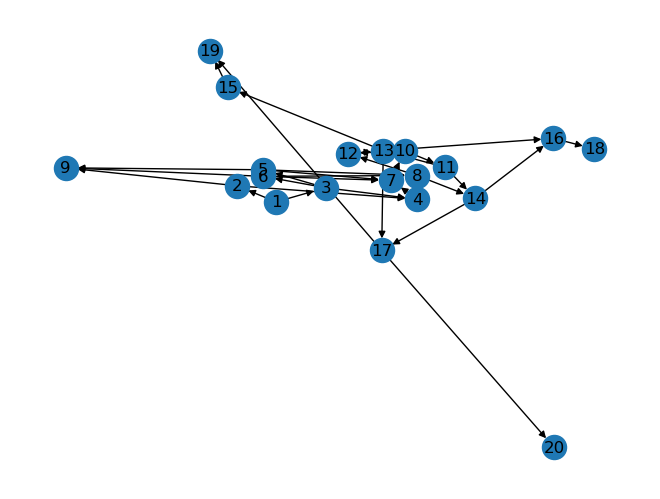

In [81]:
nx.draw(p_graph, with_labels=True)

In [82]:
a = np.array([1,2,3])
a = np.expand_dims(a, 0)
np.vstack((a,a))

array([[1, 2, 3],
       [1, 2, 3]])